In [7]:
%run RSCM_Spatial.py
import numpy as np

# crop-associated parameters
cpara = {
    'Tbase'    : 0.0,      # Tbase, base temperature                                     
    'k'        : 0.65,      # k, Light extinction coefficient                             
    'RUE'      : 2.01,      # RUE, radiation use efficiency                               
    'SLA'      : 0.016,     # SLA, specific leaf area                                     
    'beta1'    : 0.45,      # beta1, ratio of SR to PAR                                   
    'eGDD'     : 0.0,       # GDD at plant emergence                                
    'pd'       : 5          # parameter d
}

# ET-associated parameters
ET_para = {
    'a_ndvi'   : 0.60,     # conv. parameter a in NDVI = a * LAI ^ b, rice = 0.60 (Ko et al., 2015)
    'b_ndvi'   : 0.35,     # conv. parameter b in NDVI = a * LAI ^ b, rice = 0.35 (Ko et al., 2015) 
    'd_para1'  : 0.49,     # damping parameter (corr. between LAI & T/ET0), rice = 0.49 (Nay-Htoon et al, 2018)
    'd_para2'  : 0.8,      # damping parameter (corr. between NDVI & LAI), rice = 0.8 (Nay-Htoon et al, 2018)
    'VI_max'   : 1.0,      # max VI or LAI
    'VI_min'   : 0.01,     # min VI or LAI
    'kc_max'   : 1.2,      # max value of crop coefficient (Kc), rice = 1.2 (FAO 56, Allen et al., 1998)
    'ini_D'    : 20,       # init., initial crop development period : rice = 30 (FAO, Allen et al., 1998)
    'dev_D'    : 30,       # Dev., development period : rice = 30
    'mid_D'    : 30,       # mid., mid development period : rice = 80
    'late_D'   : 20,       # late, late development period : rice 40
    'k_ini'    : 1.05,     # initial Kc : rice = 1.05
    'k_mid'    : 1.20,     # mid Kc : rice = 1.20
    'k_end'    : 0.60,     # end Kc : rice = 0.90-60
    'fC_soil'  : 0.29,     # field capacity of the soil water (0.07 ~ 0.40), silt loam = 0.22-0.36
    'wiltPoint': 0.15,     # wilting point of the soil water (0.02 ~ 0.24), silt loam = 0.09-0.21
    'REW'      : 9.5,      # readily evaporated water (2 ~ 12 mm), silt loam = 8-11
    'kc_opt'   : 1,        # basal crop coeff. cal. option: 0 = FAO Kc, 1 =  VI based
    'ke_opt'   : 0,        # soil E parameter cal. option: 0 = using soil info, 1 = using VI
    'kr_opt'   : 1        # E reduction coeff. cal. option: 1 = flooded crops ; 2 >= dryland or irrigated crops
}

# productivity-associated parameters
ppara = {
    'pmGDD' : 650,      # GDD at plant maturity
     #'RTM'   : 80,        # GDD from reproduction to maturity (RTM)                     
     #'fMat'  : 5,       # fMat = mat. factor          
     #'fGC'   : 0.5,     # fGC = yield conv. factor
    'fg1'   : 0.05,      # factor of grain partitioning 1 (0.01-0.05) ### OLD for rice = 10             
    'fg2'   : 0.5,      # factor of grain partitioning 2 (0.01-0.5) ### OLD for rice = 12
    'a1'    : 0.0074,    # coeff of LUE (LUE_cint = a1 * LAI + b1, Xue et al., 2017)   
    'b1'    : 0.0107,    # coeff of LUE (LUE_cint = a1 * LAI + b1, Xue et al., 2017)   
    'a2'    : 8.571,    # coeff of max GPP (GPP_max = a2 * LAI + b2, Xue et al., 2017)
    'b2'    : 4.081     # coeff of max GPP (GPP_max = a2 * LAI + b2, Xue et al., 2017)  
}

# location parameters
lpara = {
    'lat'   : 34.0,     # Latitude of the site
    'elev'  : 14,       # Elevation of the site
    'k_Rs'  : 0.11      # Rad adj. coef. (default=0.17,inland=0.16,coast=0.19,Gwangju=0.09)
}

fmLAI    = 10        # factor of max LAI
start    = 57       # start, Start at planting
nrecords = 150       # maximum number of days allowed in simulation since the starting date
  
# Initial guesses of unknown parameters
pa    = 0.1       # parameter a
pb    = 0.00125   # parameter b
pc    = 0.00125   # parameter c
L0    = 0.02      # parameter L0
rGDD  = 550       # parameter rGDD
para0 = np.array((pa, pb, pc, L0, rGDD))

# Under the Bayesian approach, Gaussian priors are applied to the transformed (a,b,c,L0,rGDD)
# Ranges of (a,b,c,L0) are [0,1], so logistic transform is applied
# Range of rGDD is (0,infty), so log transform is applied
prior_mean_tran = para0         # Choose the inversely transformed prior mean
prior_cov = np.diag(1/para0)    # Choose the covariance matrix of the prior


In [8]:
###########################################################
# --- Example that estimate the RSCM with LAI data ---
###########################################################

# Step 1
# Objective     : To estimate (a,b,c,L0,rGDD)
# obs_d         : Stores the observed data of LAIIs, not necessarily observed daily as matrix form.
# wx_data       : Stores the 365 daily obseravations of weather data
# bayOpt        : 0 = Not Bayesian, 1 = Bayesian
# ODOYLAI       : Observed DOYs and the corresponding LAI values

bayOpt = 0
obs_d_2d = np.genfromtxt('Data/LAI_Chokyung_spring_wheat_2018.OBS', dtype='float')                     # read VI obs data for parameter estimation
wx_data_2d = np.genfromtxt('Data/Gwangju_2018.WXD', dtype='float')      # read weather data
wx_data_0, obs_d_0, sub_paddyFields_0,sub_plantingDate_0 = create_3D_data_from_one_pixel(wx_data_2d,obs_d_2d,start)

# Notes: In Optim_RSCM, the arguments prior_cov, prior_mean can be dropped if bayOpt = 0
(paraout,ODOYLAI) = Optim_RSCM_LAI(cpara,fmLAI,nrecords,wx_data_0,obs_d_0,sub_paddyFields_0,sub_plantingDate_0,para0,bayOpt,prior_cov,prior_mean_tran)
print(paraout[0,:])
print(ODOYLAI[0,:,:])

[2.82204346e-04 1.13049359e-02 1.25000000e-03 8.80876299e-03
 7.54650000e+02]
[[100.     1.65]
 [106.     1.84]
 [111.     2.89]
 [117.     3.57]
 [124.     4.19]
 [128.     4.28]
 [134.     4.44]
 [141.     4.63]
 [149.     4.08]]


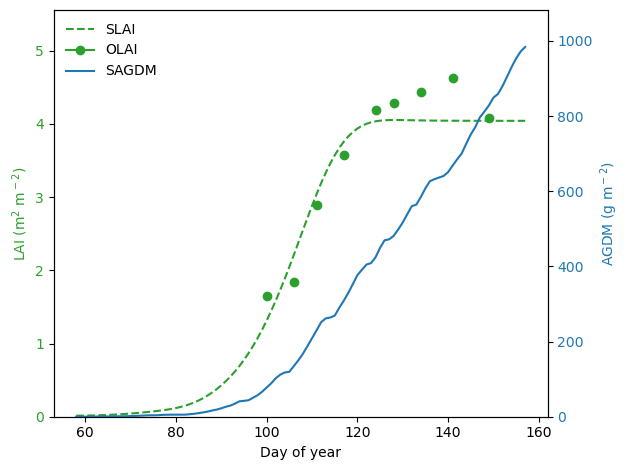

In [9]:
# Step 2
# Objective     : Simulate the GRAMI process and display the results
# wx_data       : Stores the 365 daily obseravations of weather data
# paraout       : Estimated parameters obtained in Step 1
# ODOYLAI       : Observed DOYs and the corresponding LAI values implied from VIs using coef, Sigma in Step 1

(cyield,RSCMProcess)=sim_cG(paraout,ODOYLAI,ET_para,ppara,lpara,cpara,sub_plantingDate_0,wx_data_0)
paraoutOne,cyieldOne,RSCMProcessOne = retrieve_RSCMProcessOne(paraout,cyield,RSCMProcess,0)

plot_cG(RSCMProcessOne)
outf = open('OutputSpatial/sim_cGrowth_Rice_LAI.out', 'w')
out_file_cG(outf,paraoutOne,cyieldOne,RSCMProcessOne)
outf.close()